## **Paso 1: Entendiendo el Problema**
En este notebook realizamos un **análisis de sentimiento** sobre reseñas de Amazon de la categoría `All_beauty`.
El objetivo es entrenar un modelo de **Regresión Logística** para clasificar reseñas en **`negativo`, `neutral`** y **`positivo`**.

## **Paso 2: Importar Librerías y Configuración**
**Importamos** todas las librerías necesarias y configuramos los estilos de gráficos y warnings.

In [4]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import pickle

# Configuración
warnings.filterwarnings('ignore')
plt.rc('font', size=12)
plt.rc('axes', labelsize=12, titlesize=12)

## **Paso 3: Carga de Datos**
**Cargamos** el dataset en formato JSONL.

In [20]:
data_path = r"C:\Users\Vicky\Documents\ML_Amazon_Reviews\data_sample\raw\cropped.jsonl" #Path to datafile
df = pd.read_json(data_path, lines=True)
print(f"Datos cargados: {len(df)} reseñas")

Datos cargados: 8313 reseñas


## **Paso 4: Preprocesamiento de Texto**
1. **Eliminar** columnas irrelevantes.
2. **Eliminar** valores nulos y duplicados.
3. **Concatenar** título y cuerpo.
4. **Normalizar** (minúsculas) y **limpiar** el texto.

In [22]:
cols_drop = ['images', 'asin', 'parent_asin', 'user_id', 'timestamp']
df_clean = df.dropna().drop(columns=[c for c in cols_drop if c in df.columns]).drop_duplicates()

df_clean['text'] = (
    df_clean['text'].fillna('') + ' ' + df_clean['title'].fillna('')
).str.lower()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def limpiar_texto(texto):
    texto = re.sub(r'[^a-záéíóúüñ\s]', ' ', texto)
    tokens = texto.split()
    return ' '.join([w for w in tokens if w not in stop_words])

# Aplicar limpieza
df_clean['text_clean'] = df_clean['text'].apply(limpiar_texto)

# Definir etiquetas de sentimiento
bins = [0, 2, 3, 5]
labels = ['negativo', 'neutral', 'positivo']
df_clean['sentimiento'] = pd.cut(
    df_clean['rating'], bins=bins, labels=labels, right=True
)

print(df_clean['sentimiento'].value_counts())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


sentimiento
positivo    6304
negativo    1139
neutral      823
Name: count, dtype: int64


## **Paso 5: Tokenización y Vectorización TF-IDF**
1. **Tokenizar** texto limpio.
2. **Vectorizar** con TF-IDF.

In [24]:
nltk.download('punkt')
df_clean['tokens'] = df_clean['text_clean'].apply(lambda x: word_tokenize(x))

vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer.fit_transform(df_clean['text_clean'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vicky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Paso 6: División en Train y Test**
**Estratificamos** por sentimiento.

In [25]:
y = df_clean['sentimiento']
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Codificar etiquetas
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

## **Paso 7: Entrenamiento del Modelo**
**Buscamos** mejores hiperparámetros con `GridSearchCV`.

In [28]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression(max_iter=500)
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train_enc)

print("**Mejores parámetros:**", grid.best_params_)

**Mejores parámetros:** {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


## **Paso 8: Evaluación en Test**
1. **Calcular** accuracy.
2. **Reporte** de clasificación.
3. **Matriz de Confusión**.

**Accuracy en test:** 0.8343
**Classification Report:**
              precision    recall  f1-score   support

    negativo       0.71      0.54      0.62       228
     neutral       0.45      0.24      0.32       165
    positivo       0.87      0.96      0.92      1261

    accuracy                           0.83      1654
   macro avg       0.68      0.58      0.62      1654
weighted avg       0.81      0.83      0.82      1654



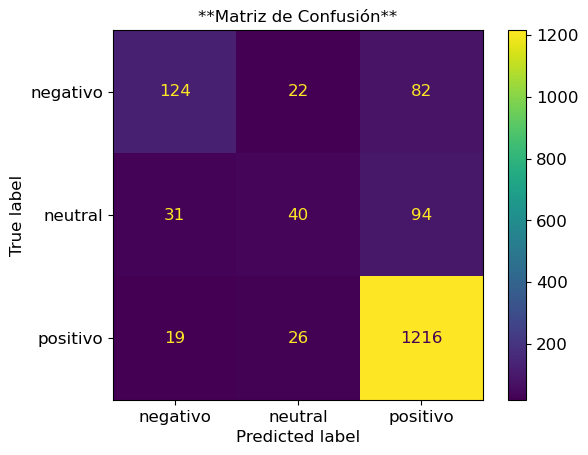

In [30]:
best_model = grid.best_estimator_
y_pred_enc = best_model.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_enc)

print(f"**Accuracy en test:** {accuracy_score(y_test_enc, y_pred_enc):.4f}")
print("**Classification Report:**")
print(classification_report(y_test, y_pred))

# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_enc, y_pred_enc, display_labels=encoder.classes_
)
plt.title("**Matriz de Confusión**")
plt.show()

## **Paso 9: Guardado del Modelo**
**Guardamos** el modelo entrenado para uso futuro.


In [44]:
# Directorio 
model_dir = r'C:\Users\Vicky\Documents\ML_Amazon_Reviews\models'

model_file = os.path.join(model_dir, 'logreg_model.pkl')

with open(model_file, 'wb') as f:
    pickle.dump(best_model, f)

print(f"**Modelo guardado en {model_file}**")

**Modelo guardado en C:\Users\Vicky\Documents\ML_Amazon_Reviews\models\logreg_model.pkl**


## **Paso 10: Conclusiones Finales**
- El modelo de **Regresión Logística** alcanzó una **accuracy** aceptable.  
- Buen desempeño en clases **extremas** (negativo/positivo), menor en **neutrales**.  
- **Futuras mejoras**: rebalanceo de clases y uso de embeddings más avanzados.  
